In [2]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os, sys
from astropy.io import ascii
import astropy.constants
import cmcrameri as cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
scripts_path = "../../scripts" #os.path.join(repo_root, 'scripts')
sys.path.append(scripts_path)

import prior_funcs, utils
from pitchfork_funcs import emulator
from pitchfork_funcs import nested_sampler



import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

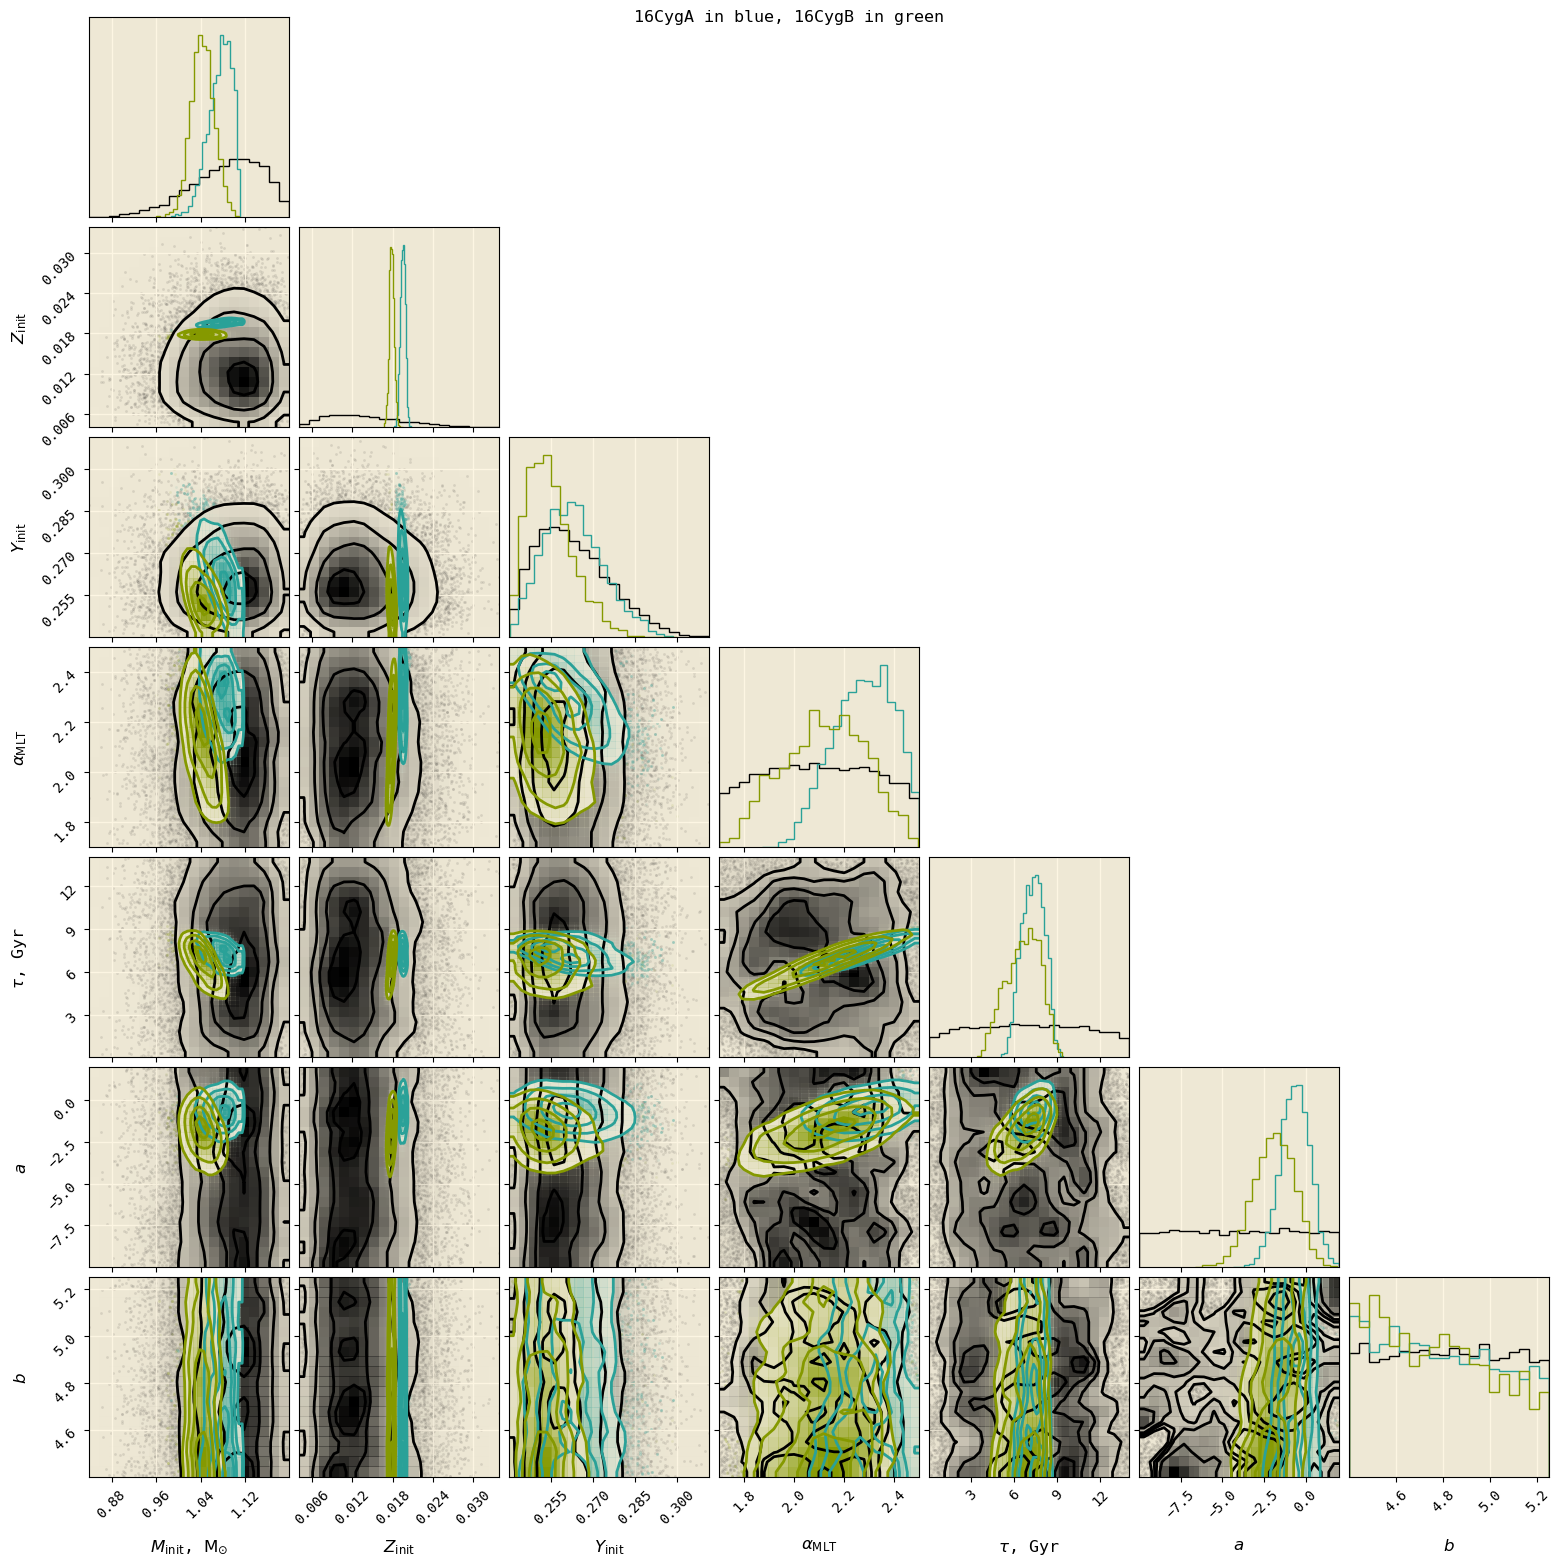

In [3]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

size = 10000
prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'

titles = [r'$M_{\mathrm{init}}$, $\mathrm{M}_{\odot}$', r'$Z_{\mathrm{init}}$', r'$Y_{\mathrm{init}}$', r'$\alpha_{\mathrm{MLT}}$', r'$\tau$, Gyr', r'$a$', r'$b$']

figure = corner.corner(prior_samples.T, labels = titles, color=corner_color, hist_kwargs={'density':True}, smooth=True);

path = f'16CygA/'

star_json = path + f'16CygA.json'

star_df = pd.read_json(star_json).dropna(axis=1)

published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

with open(path+f'/samples.pkl', 'rb') as fp:
 samples = pickle.load(fp)
    
corner.corner(samples['samples'], fig=figure, color=colors[1], hist_kwargs={'density':True}, smooth=True);

path = f'16CygB/'

star_json = path + f'16CygB.json'

star_df = pd.read_json(star_json).dropna(axis=1)

published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

with open(path+f'/samples.pkl', 'rb') as fp:
 samples = pickle.load(fp)
    
corner.corner(samples['samples'], fig=figure, color=colors[2], hist_kwargs={'density':True}, smooth=True);


plt.suptitle('16CygA in blue, 16CygB in green')
figure.patch.set_alpha(0.0)
#plt.savefig('figs/16Cygs_prior.png', bbox_inches='tight')

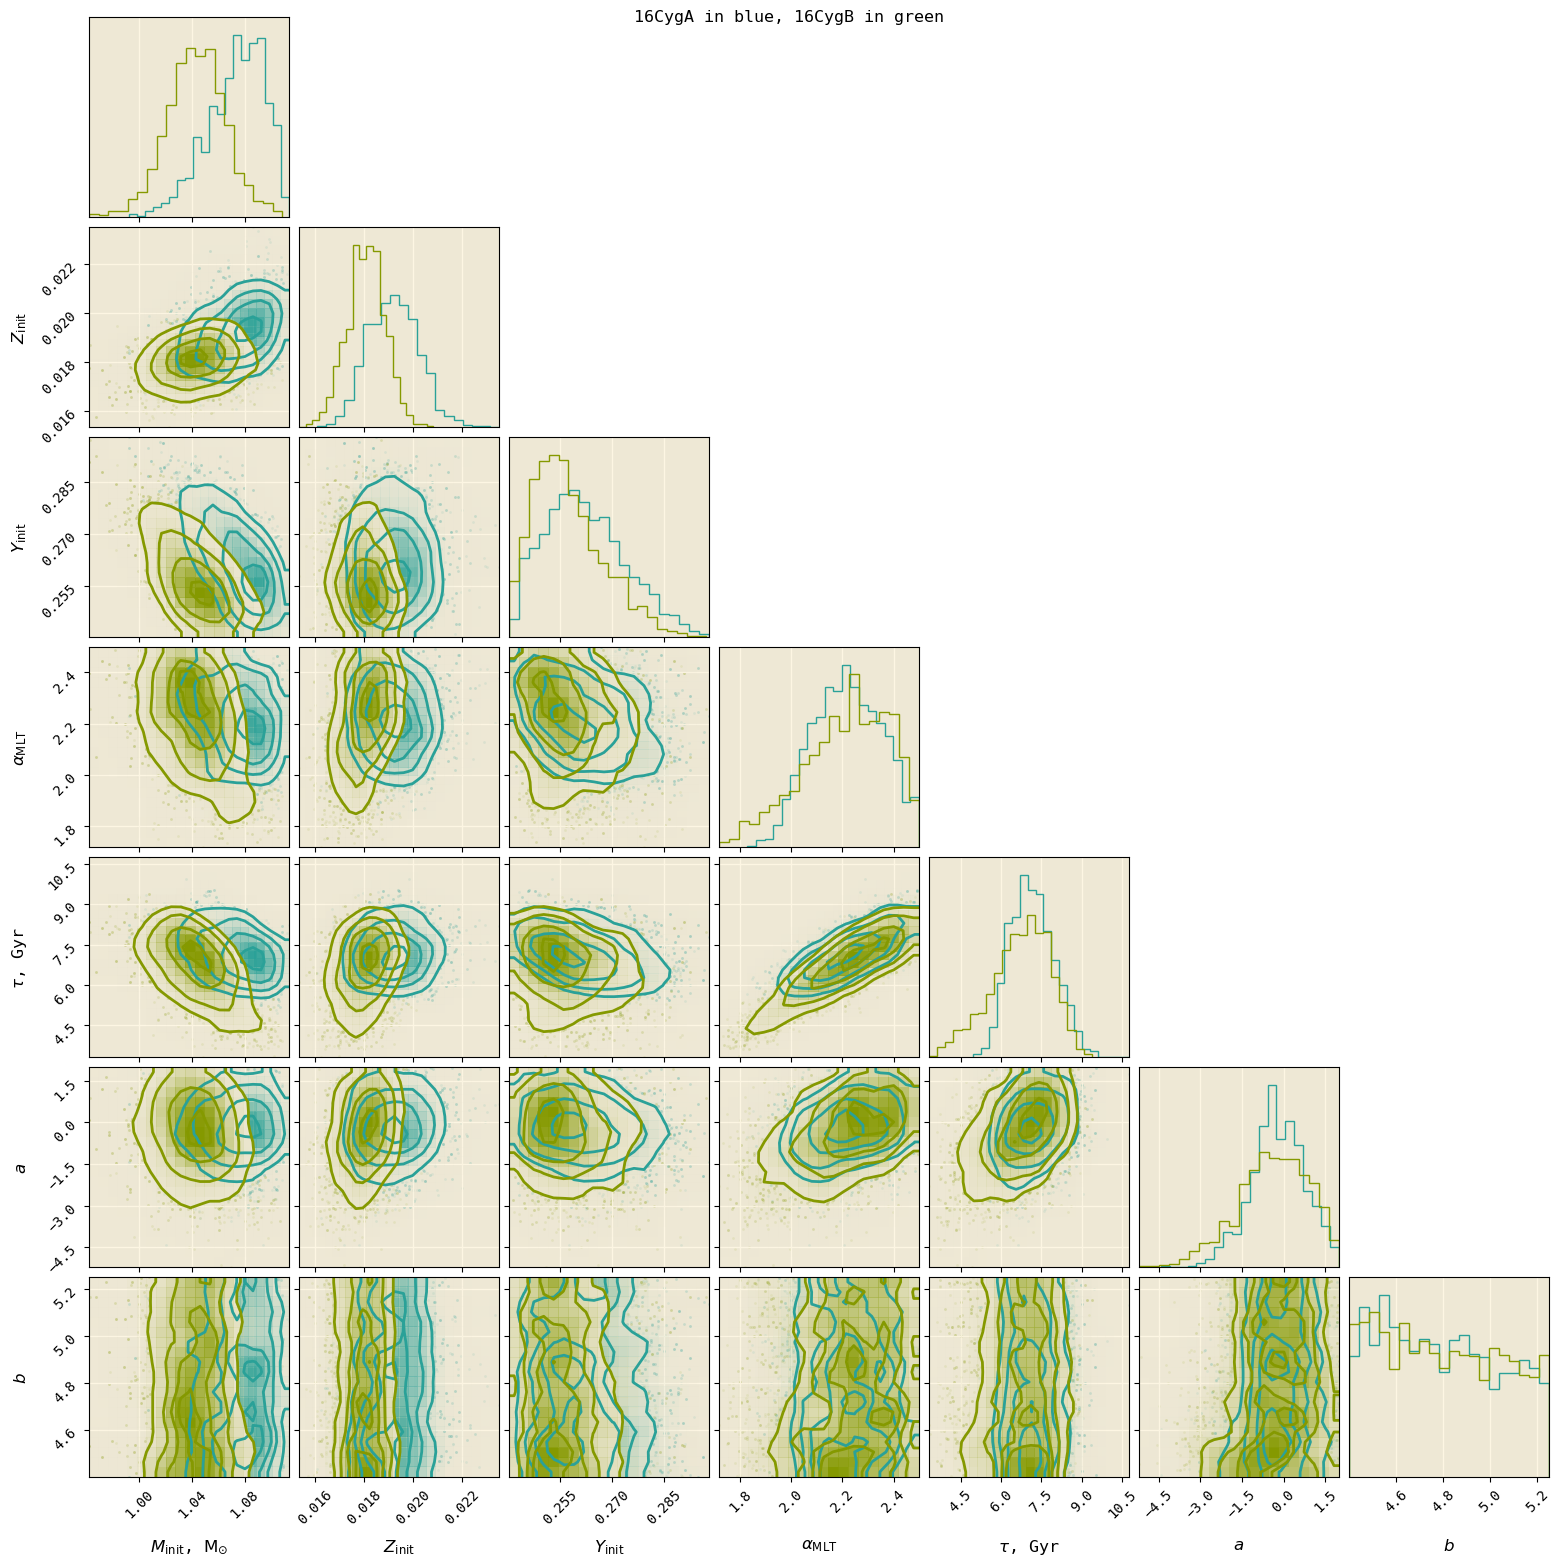

In [15]:
titles = [r'$M_{\mathrm{init}}$, $\mathrm{M}_{\odot}$', r'$Z_{\mathrm{init}}$', r'$Y_{\mathrm{init}}$', r'$\alpha_{\mathrm{MLT}}$', r'$\tau$, Gyr', r'$a$', r'$b$']


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

path = f'stars/16CygA/'

star_json = path + f'16CygA.json'

star_df = pd.read_json(star_json).dropna(axis=1)

published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

with open(path+f'/samples.pkl', 'rb') as fp:
 samples = pickle.load(fp)
    
figure = corner.corner(samples['samples'], color=colors[1], hist_kwargs={'density':True}, smooth=True, labels = titles);

path = f'stars/16CygB/'

star_json = path + f'16CygB.json'

star_df = pd.read_json(star_json).dropna(axis=1)

published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))

with open(path+f'/samples.pkl', 'rb') as fp:
 samples = pickle.load(fp)
    
corner.corner(samples['samples'], fig=figure, color=colors[2], hist_kwargs={'density':True}, smooth=True);


plt.suptitle('16CygA in blue, 16CygB in green')

figure.patch.set_alpha(0.0)
plt.savefig('figs/16Cygs_noprior.png', bbox_inches='tight')